In [1]:
%matplotlib inline

In [2]:
import pandas as pd

In [3]:
import csv
import matplotlib.pyplot as plt

In [4]:
from scipy import stats

In [5]:
import math
import numpy as np

In [119]:
df_ON_OF = pd.read_csv("ON_OF.txt", sep='\t')

In [120]:
df_YN_ON = pd.read_csv("YN_ON.txt", sep='\t')

In [121]:
df_YF_OF = pd.read_csv("YF_OF.txt", sep='\t')

In [122]:
df_YN_YF = pd.read_csv("YN_YF.txt", sep='\t')

In [123]:
df_ON = df_ON_OF[[19,6,7,8,9]];

In [124]:
df_OF = df_ON_OF[[19,10,11,12,13]]

In [125]:
df_YN = df_YN_ON[[19,6,7,8,9]]

In [126]:
df_YF = df_YN_YF[[19,10,11,12,13]]

In [127]:
def drop_dup(d):
    d = d.drop_duplicates(subset='gene', keep='first')
    return d

def merge(d1, d2):
    return pd.merge(d1, d2, how='outer', on='gene')

In [132]:
dft = merge(df_ON, df_OF)

In [133]:
dft = merge(dft, df_YN)

In [134]:
dft = merge(dft, df_YF)

In [135]:
dft = drop_dup(dft)

In [136]:
dft.dropna(thresh=(2), axis=0);

In [137]:
dft = dft[pd.notnull(dft).all(axis=1)]

In [140]:
df = dft

In [144]:
state_dict = {'AT2.young.flu.20150416': 'YF', 'AT2.old.naive.20150416': 'ON', 
                 'AT2.old.flu.20150416': 'OF', 'AT2.young.naive.20150416': 'YN'}

In [145]:
def rename_cols(df, state_dict):
    cols = df.columns
    temp_cols = list(cols)
    #print temp_cols
    for c in range(len(cols)):
        state_name = cols[c][:-2]
        #sample_num = cols[c][-2:]
        total_name = cols[c]
        #print state_name
        if state_name in state_dict:
            new_state_name = state_dict[state_name]
            new_col = total_name.replace(state_name, new_state_name)
            temp_cols[c] = new_col
            #print abb_pair_dict[state_name]
    df.columns = temp_cols
    #print temp_cols
    return df
        
    

In [146]:
df = rename_cols(df, state_dict)

In [206]:
len(df)

14285

In [46]:
def df_to_names(df):
    
    name_dict = {}
        
    for i in range(1,len(df.columns)):
        name = df.columns[i][:-2]
        if name in name_dict:
            name_dict[name].append(i)
        else:
            name_dict[name] = [i]
            
    return name_dict

In [30]:
name_dict = df_to_names(df)

In [31]:
def unique(a, b):
    return list(set(a) != set(b))
def intersect(a, b):
    return list(set(a) & set(b))
def union(a, b):
    return list(set(a) | set(b))

In [208]:
def t_stat(df, names):
    
    ### Df has samples only, no gene
    #print df
    #names = df_to_names(df)
    #print "t-stat names", names #names[0], name_dict[names[0]]
    n_samples1 = len(name_dict[names[0]])
    n_samples2 = len(name_dict[names[1]])
    
    index1 = 0
    index2 = index1 + n_samples1
    
    #print "nsamps", n_samples1, n_samples2
    indices1 = [index1 + i for i in range(n_samples1)]
    indices2 = [index2 + i for i in range(n_samples2)]
    
    values1 = [df[df.columns[i]] for i in indices1]
    values2 = [df[df.columns[i]] for i in indices2]
    
    mean1 = sum(values1)/n_samples1
    mean2 = sum(values2)/n_samples2
    
    var1_num = [(values1[i] - mean1)**2 for i in range(n_samples1)]
    var2_num = [(values2[i] - mean2)**2 for i in range(n_samples2)]
    
    var1 = sum(var1_num)/(n_samples1 - 1)
    var2 = sum(var2_num)/(n_samples2 - 1)
    
    t_stat = (mean1 - mean2) / (var1/n_samples1 + var2/n_samples2)**0.5
    pval = stats.t.sf(np.abs(t_stat), n_samples1-1)*2 
    
    logfc = np.log2(mean2/mean1)
    
    diff = mean2 - mean1
    
    return [pval, logfc, diff, mean1]

In [209]:
### Create new temp dataframe with cols ['samp1a','samp1b','samp2a','samp2b','gene']
### Add cols for logfc, pval
def names_to_df(names):
       
    # For first name    
    #print "names to df", names
    indices = list(name_dict[names[0]])
    indices.insert(0,0)
    df_temp1 = df.ix[:,indices]
    
    # For second name
    indices = list(name_dict[names[1]])
    indices.insert(0,0)
    df_temp2 = df.ix[:,indices]
    
    dft = pd.merge(df_temp1, df_temp2, how='outer', on='gene');
    
    dft = dft.ix[1:];
    dft_float = dft.ix[:,1:].astype('float');
    dft_float = dft_float[dft_float > 0];

    dft['pval'], dft['logfc'], dft['diff'], dft['mean'] = t_stat(dft_float, names)

    return dft
    #dft = merge(dft)

In [210]:
names_to_df(pairs[0])

,gene,YN.1,YN.2,YN.3,YN.4,ON.1,ON.2,ON.3,ON.4,pval,logfc,diff,mean
1,Cdc45,0.076083,0.077795,0.014816,0.027971,0.097670,0.040609,0.069904,0.074135,0.363589,0.521585,0.021413,0.049166
2,Narf,1.160905,1.262395,0.627976,0.758754,0.894176,0.757337,0.607386,0.843899,0.364325,-0.296232,-0.176808,0.952507
3,Cav2,13.010706,12.463725,12.373726,12.236357,10.409801,10.497557,11.710880,10.361103,0.016588,-0.220721,-1.776293,12.521129
4,Klf6,32.573386,35.545164,48.489444,39.298792,47.013339,41.137221,44.567283,45.876615,0.221232,0.196004,5.671918,38.976697
5,Scmh1,0.254562,0.305893,0.269376,0.263694,0.268831,0.266620,0.266987,0.288828,0.966714,-0.002984,-0.000565,0.273381
6,Cox5a,3.805504,3.726723,2.922542,3.652031,4.265999,3.509320,3.594959,3.849834,0.371172,0.109588,0.278328,3.526700
7,Tbx2,2.713025,0.895164,2.386794,2.253011,0.983380,1.362911,1.700905,1.244032,0.182249,-0.640441,-0.739191,2.061998
8,Tbx4,0.454860,0.212615,0.236208,0.237833,0.114189,0.215808,0.204317,0.090050,0.140830,-0.870492,-0.129288,0.285379
9,Ngfr,0.206129,0.037058,0.123511,0.202085,0.032568,0.090275,0.058274,0.070629,0.153258,-1.175911,-0.079259,0.142196
10,Wnt9a,0.225326,0.157986,0.245724,0.209860,0.138844,0.176394,0.186325,0.188192,0.188506,-0.282408,-0.037285,0.209724


In [37]:
def reset_pairs(df):
    
    name_dict = df_to_names(df)
    names = name_dict.keys()
    n_names = len(names)
    pairs = [[[names[i], names[j]] for i in range(n_names) if i != j] for j in range(n_names)]
    pairs = [pair for sublist in pairs for pair in sublist]
    return pairs

pairs = reset_pairs(df)

In [54]:
pairs_rel = [['YN','ON'],['YN','YF'],['ON','OF']]

In [282]:
def filter_df(df, pcut = 0.05, fcut = 0.15):
    
    ### Filter all by pvalue
    df = df[df['pval'] < pcut]
    
    ## Highly upregulated
    df1 = df[df['logfc'] > fcut]
    
    ## Highly downregulated
    df2 = df[df['logfc'] < -fcut]
    
    ## Weakly upregulated
    df3 = df[df['logfc'] < fcut]
    df3 = df3[df3['logfc'] > 0]
    
    ## Weakly downregulated
    df4 = df[df['logfc'] > -fcut]
    df4 = df4[df4['logfc'] < 0]
    
    return [df1, df2, df3, df4]
        

In [285]:
n_groups = 4
for p1 in range(1,2):#len(pairs_rel)):
    
    pair1 = pairs_rel[p1]
    print pair1
    df1 = names_to_df(pair1)
    df1_groups = filter_df(df1)
    df1_genes = [group['gene'] for group in df1_groups]
    
    for p2 in range(2,3): #p1+1, len(pairs_rel)):
        
        pair2 = pairs_rel[p2]
        print pair2
        df2 = names_to_df(pairs_rel[p2])
        df2_groups = filter_df(df2)
        df2_genes = [group['gene'] for group in df2_groups]
        
        common_genes = [pd.DataFrame(intersect(df1_genes[i], df2_genes[i])) for i in range(n_groups)]
        for i in range(n_groups):
            common_genes[i].columns = ['gene']
        print "# in common", [len(common_genes[i]) for i in range(n_groups)]
        print "# in group1", [len(genes) for genes in df1_genes]
        #print common_genes[0]
        ## Of the common genes, which are in first pair
        #print df1_groups[0]
        df1_common = [pd.merge(common_genes[i], df1_groups[i], how='left') for i in range(n_groups)]
        df2_common = [pd.merge(common_genes[i], df2_groups[i], how='left') for i in range(n_groups)]
        #print "In common with pair 1"
        
        ## In
        print "In first group"
        for group in df1_groups:
            print grp_stats(group)
            
        print "In second group"
        for group in df2_groups:
            print grp_stats(group)
            
        print "In common, first group"
        for group in df1_common:
            print grp_stats(group)
            
        print "In common, second group"
        for group in df2_common:
            print grp_stats(group)
            
            #    mean = np.mean(group['diff'])
        #    print len(group), mean, len(group*mean)
            
        ## And which are in the second pair.
        #df2_common = [pd.merge(common_genes[i], df2_groups[i], how='left') for i in range(n_groups)]
        #print "In common with pair 2"
        #for group in df1_common:
            
        #    mean = np.mean(group['diff'])
        #    print len(group), mean, len(group*mean)
  

['YN', 'YF']
['ON', 'OF']
# in common [679, 457, 1, 1]
# in group1 [1135, 917, 6, 6]
In first group
[1135, 9.0, 10215.0, 8.0]
[917, -10.0, -9170.0, 43.0]
[6, 3.0, 18.0, 26.0]
[6, -1.0, -6.0, 16.0]
In second group
[1194, 11.0, 13134.0, 10.0]
[1356, -8.0, -10848.0, 32.0]
[8, 2.0, 16.0, 25.0]
[17, -2.0, -34.0, 19.0]
In common, first group
[679, 14.0, 9506.0, 10.0]
[457, -18.0, -8226.0, 80.0]
[1, 1.0, 1.0, 6.0]
[1, -5.0, -5.0, 51.0]
In common, second group
[679, 16.0, 10864.0, 11.0]
[457, -17.0, -7769.0, 77.0]
[1, 1.0, 1.0, 6.0]
[1, -3.0, -3.0, 47.0]


In [ ]:
####  Young Illness
####  Old Illness
####  
#### logFC  diff
####  1.4   

/Users/tjyacoub/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: order is deprecated, use sort_values(...)


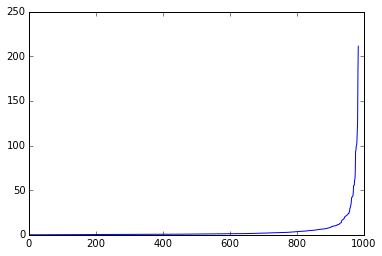

In [261]:
diffcut = 0
dfg = df_groups[2]
dfg = dfg[dfg['diff'] > diffcut] #['diff']
#dfg = dfg[dfg['logfc'] > 1.4]
gser = dfg['diff']
plt.plot(gser.order()[:-1])
plt.show()

/Users/tjyacoub/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: order is deprecated, use sort_values(...)


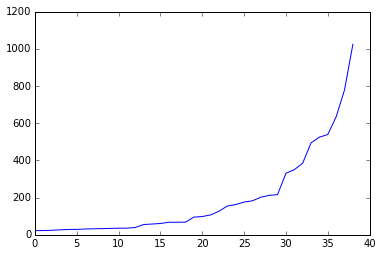

In [268]:
diffcut = 20
dfg = df_groups[0]
dfg = dfg[dfg['diff'] > diffcut] #['diff']
#dfg = dfg[dfg['logfc'] > 1.4]
gser = dfg['diff']
plt.plot(gser.order()[:])
plt.show()

/Users/tjyacoub/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':


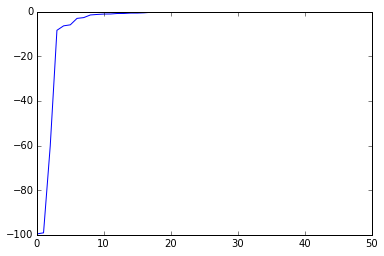

In [243]:
plt.plot(df_groups[1]['diff'].order())
plt.show()

In [191]:
tpair = ['YN','ON']
df1 = names_to_df(tpair)
df1_groups = filter_df(df1)
df1_genes = [group['gene'] for group in df1_groups]

In [233]:
def grp_stats(group):
    
    mean_diff = round(np.mean(group['diff']),0)
    mean_val = round(np.mean(group['mean']),0)
    tot = mean_diff*len(group)
    return [len(group), mean_diff, tot, mean_val]


In [215]:
for pair in pairs_rel:
    tdf = names_to_df(pair)
    df_groups = filter_df(tdf)
    print pair
    total = 0
    #totals = [np.mean(group['diff'])*len(group) for group in df_groups]
    #tt = [totals[0] + totals[2], totals[1]+totals[3]]
    #print tt
    
    for group in df_groups:
        mean = round(np.mean(group['diff']),0)
        m2 = round(np.mean(group['mean']),0)
        tot = mean*len(group)
        print len(group), mean, tot, m2
        total += tot
    print total

['YN', 'ON']
70 19.0 1330.0 8.0
54 -2.0 -108.0 3.0
509 4.0 2036.0 8.0
524 -3.0 -1572.0 16.0
1686.0
['YN', 'YF']
228 28.0 6384.0 5.0
38 -3.0 -114.0 4.0
913 4.0 3652.0 8.0
885 -10.0 -8850.0 45.0
1072.0
['ON', 'OF']
216 39.0 8424.0 10.0
48 -6.0 -288.0 9.0
986 5.0 4930.0 10.0
1325 -8.0 -10600.0 33.0
2466.0


In [34]:
### Needs dataframe with cols ('gene', 'logfc', 'pval')

def filter_genes(df, pcut = 0.05, fcut = 1.4):
    
    df_pcut = df[df['pval'] < pcut]
    
    df_fc_up = df_pcut[df_pcut['logfc'] > fcut]
    
    df_fc_dn = df_pcut[df_pcut['logfc'] < -fcut]
    
    df_pv_up = df_pcut[df_pcut['logfc'] < fcut]
    df_pv_up = df_pv_up[df_pv_up['logfc'] > 0]
    
    df_pv_dn = df_pcut[df_pcut['logfc'] < 0]
    df_pv_dn = df_pv_dn[df_pv_dn['logfc'] > -fcut]

    fc_up_genes = df_fc_up['gene']
    fc_dn_genes = df_fc_dn['gene']
    pv_up_genes = df_pv_up['gene']
    pv_dn_genes = df_pv_dn['gene']
    
    #n_up_fc = sum(df_fc_up.ix[:,'up'])
    #n_dn_fc = sum(df_fc_dn.ix[:,'dn'])
    #n_up_pv = sum(df_pv_up.ix[:,'up'])
    #n_dn_pv = sum(df_pv_dn.ix[:,'dn'])

    return [fc_up_genes, fc_dn_genes, pv_up_genes, pv_dn_genes]


In [ ]:
def sum()

In [38]:
def get_counts(names):
    
    dft = names_to_df(names)
    dft_genes = filter_genes(dft)
    dft_counts = [len(genes) for genes in dft_genes]
    return dft_counts
    

In [39]:
def pair_pair_counts(name_pairs):
    
    dft1 = names_to_df(name_pairs[0])
    dft2 = names_to_df(name_pairs[1])
    
    dft1_genes = filter_genes(dft1)
    dft2_genes = filter_genes(dft2)
    
    common_genes = [intersect(dft1_genes[i], dft2_genes[i]) for i in range(len(dft1_genes))]
    common_counts = [len(genes) for genes in common_genes]
    return common_counts
    

In [201]:
def all_counts(pairs):
    
    pairs = reset_pairs(df)
    pairs2 = list(pairs)
    
    for p in range(len(pairs)):
        #pair in pairs:
        counts = get_counts(pairs2[p])
        pairs2[p].append(counts)
        
    return pairs2

In [313]:
def common_counts(pairs):
    
    pairs = reset_pairs(df)
    pairs_temp = list(pairs)
    data = []
    
    for p in range(len(pairs)):
        pair1 = pairs[p]
        
        for p2 in range(p+1,len(pairs)): 
            pair2 = pairs[p2]
            #if pair1 != pair2:
            counts = pair_pair_counts([pair1, pair2])
            data12 = [[pair1, pair2],[counts]]
            data.append(data12)
            
        
    return data

In [356]:
def common_ratio(pairs):
    
    pairs = reset_pairs(df)
    pairs_temp = list(pairs)
    data = []
    
    for p in range(len(pairs)):
        pair1 = pairs[p]
        
        for p2 in range(p+1,len(pairs)): 
            pair2 = pairs[p2]
            #if pair1 != pair2:
            counts = pair_pair_counts([pair1, pair2])
            data12 = [[pair1, pair2],float(counts[0])/float(counts[1])]
            data.append(data12)
            
        
    return data

In [320]:
def uncommon_counts(pairs):
    
    pairs = reset_pairs(df)
    pairs_temp = list(pairs)
    data = []
    
    for p in range(len(pairs)):
        pair1 = pairs[p]
        counts1 = get_counts(pair1)
        for p2 in range(p+1,len(pairs)): 
            pair2 = pairs[p2]
            #if pair1 != pair2:
            counts2 = get_counts(pair2)
            counts_pair = pair_pair_counts([pair1, pair2])
            data12 = [[pair1, counts1, pair2, counts2],[counts_pair]]
            data.append(data12)
            
    return data

In [357]:
count_data = common_ratio(pairs)

In [301]:
from operator import itemgetter

In [358]:
count_data.sort(key=itemgetter(1), reverse=True) #, keyfor pairs in count_data:


In [360]:
for data in count_data:
    if data[0][0][0] == data[0][1][0]:
        print data

[[['YN', 'YF'], ['YN', 'OF']], 8.666666666666666]
[[['ON', 'YF'], ['ON', 'OF']], 5.65625]
[[['YN', 'ON'], ['YN', 'YF']], 2.272727272727273]
[[['OF', 'YN'], ['OF', 'YF']], 1.3225806451612903]
[[['YN', 'ON'], ['YN', 'OF']], 1.3055555555555556]
[[['ON', 'YN'], ['ON', 'YF']], 1.05]
[[['ON', 'YN'], ['ON', 'OF']], 0.7692307692307693]
[[['YF', 'ON'], ['YF', 'OF']], 0.75]
[[['OF', 'ON'], ['OF', 'YF']], 0.75]
[[['YF', 'YN'], ['YF', 'OF']], 0.7272727272727273]
[[['YF', 'ON'], ['YF', 'YN']], 0.12716763005780346]
[[['OF', 'ON'], ['OF', 'YN']], 0.08376963350785341]


In [359]:
count_data

[[[['ON', 'YF'], ['YN', 'OF']], 16.4],
 [[['YN', 'YF'], ['ON', 'OF']], 14.75],
 [[['ON', 'OF'], ['YN', 'OF']], 11.9375],
 [[['YN', 'YF'], ['YN', 'OF']], 8.666666666666666],
 [[['ON', 'YF'], ['YN', 'YF']], 7.863636363636363],
 [[['ON', 'YF'], ['ON', 'OF']], 5.65625],
 [[['YN', 'ON'], ['YN', 'YF']], 2.272727272727273],
 [[['YN', 'ON'], ['ON', 'OF']], 2.25],
 [[['YN', 'ON'], ['ON', 'YF']], 1.7142857142857142],
 [[['YF', 'ON'], ['ON', 'OF']], 1.5],
 [[['YN', 'YF'], ['OF', 'YF']], 1.375],
 [[['ON', 'YF'], ['OF', 'YF']], 1.3333333333333333],
 [[['YN', 'YF'], ['YF', 'OF']], 1.3333333333333333],
 [[['ON', 'OF'], ['YF', 'OF']], 1.3333333333333333],
 [[['OF', 'YN'], ['OF', 'YF']], 1.3225806451612903],
 [[['YN', 'ON'], ['YN', 'OF']], 1.3055555555555556],
 [[['YN', 'ON'], ['OF', 'ON']], 1.3],
 [[['ON', 'YN'], ['OF', 'YF']], 1.2222222222222223],
 [[['YF', 'ON'], ['YN', 'YF']], 1.1666666666666667],
 [[['OF', 'ON'], ['YF', 'OF']], 1.1666666666666667],
 [[['ON', 'YN'], ['YF', 'OF']], 1.166666666666666

In [353]:
c2 = count_data
for c in range(len(count_data)): #count_data:
    c2[c][1][0] = count_data[c][1][0][0]/count_data[c][1][0][0]
    
print count_data

TypeError: 'int' object has no attribute '__getitem__'

In [341]:

for data in count_data:
    if data[0][0][0] == 'ON' and 'YN' in data[0][0]:
        print data

[[['ON', 'YN'], ['ON', 'YF']], [[42, 40, 157, 177]]]
[[['ON', 'YN'], ['OF', 'YN']], [[36, 47, 278, 132]]]
[[['ON', 'YN'], ['OF', 'YF']], [[33, 27, 94, 81]]]
[[['ON', 'YN'], ['YF', 'YN']], [[11, 25, 155, 70]]]
[[['ON', 'YN'], ['ON', 'OF']], [[10, 13, 88, 135]]]
[[['ON', 'YN'], ['YN', 'OF']], [[9, 8, 10, 11]]]
[[['ON', 'YN'], ['YN', 'YF']], [[7, 7, 38, 30]]]
[[['ON', 'YN'], ['YF', 'OF']], [[7, 6, 1, 2]]]


In [44]:

#### [state1, state2, state3, ..., stateN]
### [state1, state2, state3, ..., stateN]

### N-1 combinations for each state
### [state1-state2, state1-state3, state1-stateN ]

### N/2 * N combinations, *2 for reverse

### input dfs = [df1, df2]
def compare_edges(dfs):
    
    df1_genes = filter_genes(dfs[0])
    df2_genes = filter_genes(dfs[1])
    
    gene_totals = [[df1_genes[i], df2_genes[i]] for i in range(len(df1_genes))]
    gene_intersect = [intersect(i,j) for i,j in gene_totals]
    gene_percent = [float(len(gene_intersect[i]))/float(len(df1_genes[i])) for i in range(len(df1_genes))]
    ### What do we want?
    ### [[% up FC_1, % up FC_2],[% dn FC_1, %dn FC_1], [% up PV1, % up PV2], [% dn PV1, % dn PV2]]
    
    return gene_percent
    
    #n0 = len(dfres[k][0])
    #n1 = len(dfres[k][1])
    #ns = len(inter)
    
    #genes_shared_ct[k] = [n0, round(float(ns)/n0,3), n1, round(float(ns)/n1,3), ns]
    #gene_totals[k] = [len(dfres[k][0]),len(dfres[k][1])] 
                      #genes_unique[k] = unique(dfres[k][0],dfres[k][1])
    #gene_ratios[k] = len(genes_union

In [289]:
#%%capture
p1 = names_to_df(pairs[0])['pval'][:10]
p2 = names_to_df(pairs[3])['pval'][:10]

In [213]:
%%capture
al_counts(pairs)

[['AT2.young.flu.20150416', 'AT2.old.naive.20150416', [707, 776, 1524, 1337]],
 ['AT2.old.flu.20150416', 'AT2.old.naive.20150416', [624, 728, 1453, 1050]],
 ['AT2.young.naive.20150416', 'AT2.old.naive.20150416', [653, 566, 701, 588]],
 ['AT2.old.naive.20150416', 'AT2.young.flu.20150416', [776, 707, 1337, 1524]],
 ['AT2.old.flu.20150416', 'AT2.young.flu.20150416', [578, 495, 503, 436]],
 ['AT2.young.naive.20150416',
  'AT2.young.flu.20150416',
  [740, 486, 1041, 1077]],
 ['AT2.old.naive.20150416', 'AT2.old.flu.20150416', [728, 624, 1050, 1453]],
 ['AT2.young.flu.20150416', 'AT2.old.flu.20150416', [495, 578, 436, 503]],
 ['AT2.young.naive.20150416', 'AT2.old.flu.20150416', [806, 652, 997, 1361]],
 ['AT2.old.naive.20150416', 'AT2.young.naive.20150416', [566, 653, 588, 701]],
 ['AT2.young.flu.20150416',
  'AT2.young.naive.20150416',
  [486, 740, 1077, 1041]],
 ['AT2.old.flu.20150416', 'AT2.young.naive.20150416', [652, 806, 1361, 997]]]

In [ ]:
names = ["FC up", "FC down", "PV up", "PV down"]
for i in range(4):
    print names[i]
    print x[i]
    #print genes_shared_ct[i] #".2f"% genes_shared_ct[i][1] 

In [ ]:
plt.plot([0.6, 0.2, 0.6, 0.5])

In [ ]:
dft = dft[pd.notnull(dft).all(axis=1)]

In [ ]:
ncols = len(dft.columns)
gene_names = dft.ix[:,0]
for i in range(1, ncols, 4):   #ncols):
    sample1_name = dft.columns[i]
    sample_list = []
    sample1 = dft.ix[:,i]
    for j in range(1, ncols):
        
        sample2_name = dft.columns[j]
        
        sample2 = dft.ix[:,j]
        #print sample1[0], sample2[0]
        logfc = np.log(sample2/sample1)
        logfc = logfc[logfc < 100]
        upreg = len(logfc[logfc > 1.4])
        downreg = len(logfc[logfc < -1.4])
        #print sample1_name, sample2_name, upreg, downreg
        dist = upreg + downreg
        regratio = upreg - downreg
        sample_list.append([sample2_name, dist, upreg, downreg])
        
    print sample1_name
    for n in sample_list:
        print n
    #print sample_list
#        print sample1/sample2

In [ ]:
def make_tree(dfs):
    ndf = len(dfs)
    mat
    for df1_ind in range(ndf):
        for df2_ind in range(df1_ind+1,ndf):
            merged_df = pd.merge(dfs[df1_ind], dfs[df2_ind], how = 'outer', on='gene')
            
            #merged_df['ratio'] = float(merged_df[[1]]) #sum(float(merged_df[[1,2,3,4]]))
            #for gene_ind in range(len(merged_df)):
        ### GET ratios
                
        ### GET SIMILARITY
        ### [ YN [1, 0.4, 0.8. 0.7],
        ###   ON [0.6, 1, 0.9, 0.2],
        ###   YF [0.4, 0.3, 1, 0.6],
        ###   OF [0.3, 0.9, 0.1, 1]]
        
        ### TREE FIGURE
        ###      YF (2)
        ###     /
        ###  YN(1)- ON(3)- OF(4)
        
        ###  [[1,2],[1,3],[3,4]]
        
        ### START WITH
        ### [[1,2],[1,3],[1,4]]
        ### [1-2] 0.3
        ### [1-3] 0.8
        ### [1-4] 0.5
        ### Then go to 2
        ### [2-1] 0.3 (ok)
        ### [2-3] 0.9 (>[1-3], change)
                    ### [[1,2],[2,3],[1,4]]
        ### [2-4] 0.2 (<[1-4], no change)
        ### On to 3...
        ### [3-1] 0.3 (ok)
        ### [3-2] 0.1 (<[1-3], no change)
        ### [3-4] 0.9 (>[1-4], change
                    ### [[1,2],[1,3],[3,4]])
        
        ### [1-3] ok
        sim = [[random.random() for i in range(ndf)] for j in range(ndf)]
        for i in range(ndf):
            ## Initialize tree starting with i
            tree = []
            for j in range(ndf):
                tree[j] = [i,j]
                #similarity_matrix sim
                
                
            for j in range(ndf):
                sim_ij = sim[i,j]
                for k in range(ndf):
                    sim_ik = sim[i,k]
                    if sim_ik > sim_ij:
                        tree[j] = [i,k]
                    
                
                
    
    #return merged_df
        
            
make_tree(dfs);

In [ ]:
import random
ndf = 4
sim = [[random.random() for i in range(ndf)] for j in range(ndf)]

In [ ]:
sim[2][3]

In [ ]:
def make_tree2():
    ndf = 10
    sim = [[random.random() for i in range(ndf)] for j in range(ndf)]
    nodes = [i for i in range(ndf)]
    for i in range(ndf):
        #print "begin", i
            ## Initialize tree starting with i
        tree = []# [0 for x in range(ndf-1)]
        
        j_nodes = [z for z in range(ndf)]
        j_nodes.remove(i)
        for j in j_nodes: 
            tree.append([i,j])
                #similarity_matrix sim
                
        n_iters = 1
        for iteration in range(n_iters):
            
            #print tree
        #print "j_nodes",j_nodes
            for j in j_nodes:
            #print tree
                sim_ij = sim[i][j]
            
                k_nodes = [z for z in range(ndf)]
                k_nodes.remove(j)
                k_nodes.remove(i)
                #print "k_nodes", k_nodes
                for k in k_nodes:
                #print "j = ", j, "k=", k
                    sim_ik = sim[i][k]
                    sim_jk = sim[j][k]
                    if sim_ik > sim_jk:
                        #print j,k, "> ", i, k
                        tree[k-1] = [j,k]
                        #print tree
            #print "end iteration", iteration, tree
            #for i in range(len(tree)):
            print sum([sim[ii][jj] for ii,jj in tree])
        printsorted(tree)
make_tree2()

In [ ]:
def make_tree_rand():
    ndf = 10
    sim = [[random.random() for i in range(ndf)] for j in range(ndf)]
    seq = [i for i in range(ndf)]

    nodes = [random.choice() for i in range(ndf)]
    n_iter = 10
    
    ### Initialize tree
    tree = []# [0 for x in range(ndf-1)]
    
    j_nodes = [z for z in range(ndf)]
    j_nodes.remove(i)
    for j in j_nodes: 
        tree.append([i,j])
                #similarity_matrix sim
    for i in range(n_iter):
        #print "begin", i
            ## Initialize tree starting with i

                
        n_iters = 1
        for iteration in range(n_iters):
            
            #print tree
        #print "j_nodes",j_nodes
            for j in j_nodes:
            #print tree
                sim_ij = sim[i][j]
            
                k_nodes = [z for z in range(ndf)]
                k_nodes.remove(j)
                k_nodes.remove(i)
                #print "k_nodes", k_nodes
                for k in k_nodes:
                #print "j = ", j, "k=", k
                    sim_ik = sim[i][k]
                    sim_jk = sim[j][k]
                    if sim_ik > sim_jk:
                        #print j,k, "> ", i, k
                        tree[k-1] = [j,k]
                        #print tree
            #print "end iteration", iteration, tree
            #for i in range(len(tree)):
            error = sum([sim[ii][jj] for ii,jj in tree])
        printsorted(tree)
make_tree_rand()

In [ ]:
def make_tree_easy():
    ndf = 10
    sim = [[random.random() for i in range(ndf)] for j in range(ndf)]
    seq = [i for i in range(ndf)]

    nodes = [random.choice() for i in range(ndf)]
    n_iter = 10
    
    ### Initialize tree
    tree = []# [0 for x in range(ndf-1)]
    
    j_nodes = [z for z in range(ndf)]
    j_nodes.remove(i)
    for j in j_nodes: 
        tree.append([i,j])
                #similarity_matrix sim
    for i in range(n_iter):
        #print "begin", i
            ## Initialize tree starting with i

                
        n_iters = 1
        for iteration in range(n_iters):
            
            #print tree
        #print "j_nodes",j_nodes
            for j in j_nodes:
            #print tree
                sim_ij = sim[i][j]
            
                k_nodes = [z for z in range(ndf)]
                k_nodes.remove(j)
                k_nodes.remove(i)
                #print "k_nodes", k_nodes
                for k in k_nodes:
                #print "j = ", j, "k=", k
                    sim_ik = sim[i][k]
                    sim_jk = sim[j][k]
                    if sim_ik > sim_jk:
                        #print j,k, "> ", i, k
                        tree[k-1] = [j,k]
                        #print tree
            #print "end iteration", iteration, tree
            #for i in range(len(tree)):
            error = sum([sim[ii][jj] for ii,jj in tree])
        printsorted(tree)
make_tree_easy()

In [ ]:
tree = [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5]]

In [ ]:
def printsorted(tree):
    tree.sort()
    tree_dict = {}
    for i in range(len(tree)):
        if tree[i][0] not in tree_dict:
            tree_dict[tree[i][0]] = [tree[i][1]]
        else:
            tree_dict[tree[i][0]].append(tree[i][1])
        
    print tree_dict
            